# ANALYSE MCIROBIOME INTERACTIONS
Based on coefficients obtained from th RERF model create microbiome interacion network and analyse it

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np
import seaborn as sns
import matplotlib.patches as mpatches

import os
import sys

from collections import Counter

MODULE_PATH = os.path.abspath('/storage/pszczerbiak/microbiome_interactions_project') # TODO load from CONFIG file
if MODULE_PATH not in sys.path:
    sys.path.append(MODULE_PATH)
    
from utils.measures import calculate_nrmse, calculate_spearman, intra_dissimilarity, inter_dissimilarity

In [3]:
sns.set_style('whitegrid')

In [2]:
%cd /storage/zkarwowska/predicting-microbiome-in-time/linear-models/linear-forest/

/storage/zkarwowska/predicting-microbiome-in-time/linear-models/linear-forest


In [4]:
taxonomy = pd.read_csv('/storage/zkarwowska/predicting-microbiome-in-time/data-processing/assign-taxonomy/taxonomy.csv', index_col=[0])
taxonomy.index.name = 'features'
taxonomy_dict = dict(zip(taxonomy.index, taxonomy.Taxon))

In [5]:
feature_importance_df = pd.read_csv('enet_feature_importance_lag5.csv', index_col=[0])
regression_coefficients_df = pd.read_csv('enet_coeff_lag5.csv', index_col=[0])

feature_importance_df[['features', 'lag']] = feature_importance_df.features.str.split('_', expand=True)
regression_coefficients_df[['features', 'lag']] = regression_coefficients_df.features.str.split('_', expand=True)
INTERCATIONS_DF = pd.merge(feature_importance_df, regression_coefficients_df,  on=['target', 'features', 'lag'])

In [54]:
INTERCATIONS_DF[['feature_taxo', 'target_taxo']] = INTERCATIONS_DF[['features', 'target']]
INTERCATIONS_DF = INTERCATIONS_DF[(INTERCATIONS_DF.coefficient!=0)&(INTERCATIONS_DF.feature_importance!=0)]

In [72]:
#assign taxonomy
TAXONOMY_INTERACTIONS = INTERCATIONS_DF.replace({"feature_taxo": taxonomy_dict, "target_taxo": taxonomy_dict})

#aplit to taxonomic level
TAXONOMY_INTERACTIONS[['feature_k', 'feature_p', 'feature_c', 'feature_o', 'feature_f', 'feature_g', 'feature_s']] = TAXONOMY_INTERACTIONS.feature_taxo.str.split(';', expand=True)
TAXONOMY_INTERACTIONS[['target_k', 'target_p', 'target_c', 'target_o', 'target_f', 'target_g', 'target_s']] = TAXONOMY_INTERACTIONS.target_taxo.str.split(';', expand=True)

### plot models coefficients & features importance

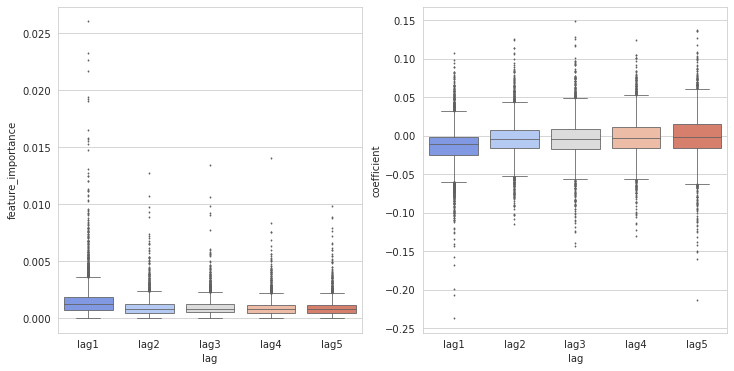

In [65]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
sns.boxplot(data=TAXONOMY_INTERACTIONS,
            x = 'lag',
            y='feature_importance', 
            width=.8,
            palette='coolwarm',
            linewidth=.8, 
            fliersize=1,
            ax=axes[0])

sns.boxplot(data=INTERCATIONS_DF,
            x = 'lag',
            y='coefficient', 
            width=.8,
            linewidth=.8, 
            palette='coolwarm',
            fliersize=1,
            ax=axes[1])

### number of interactions on each lag

In [73]:
N_INTERACTIONS_DF = []
for feature in TAXONOMY_INTERACTIONS.features.unique():
    
    df = TAXONOMY_INTERACTIONS[TAXONOMY_INTERACTIONS.features == feature]
    df = df[(df.feature_importance!=0)&(df.coefficient!=0)]

    lag1_interactions = df[df.lag == 'lag1'].shape[0]
    lag2_interactions = df[df.lag == 'lag2'].shape[0]
    lag3_interactions = df[df.lag == 'lag3'].shape[0]
    lag4_interactions = df[df.lag == 'lag4'].shape[0]
    lag5_interactions = df[df.lag == 'lag5'].shape[0]

    interaction_number = pd.DataFrame(list(zip([lag1_interactions,lag2_interactions,lag3_interactions,lag4_interactions,lag5_interactions],
                                               ['lag1', 'lag2', 'lag3', 'lag4', 'lag5'])),
                                     columns = ['no interactions', 'lag'])
    interaction_number['features'] = feature
    N_INTERACTIONS_DF.append(interaction_number)
    
N_INTERACTIONS_DF = pd.concat(N_INTERACTIONS_DF)

###  interactions strength vs number of interactions

In [74]:
def standardize_regression_coeff(df):
    
    STANDARDIZED_COEFF = []
    for feature in df['target'].unique():

        coeff_sum = df[df['target'] == feature]['coefficient'].sum()
        standardized_coeff = df[df['target'] == feature]['coefficient']/coeff_sum
        STANDARDIZED_COEFF.append(standardized_coeff)
        
    return pd.concat(STANDARDIZED_COEFF)


TAXONOMY_INTERACTIONS.coefficient = np.abs(TAXONOMY_INTERACTIONS.coefficient)
TAXONOMY_INTERACTIONS['standardized_coeff'] = standardize_regression_coeff(TAXONOMY_INTERACTIONS)
TAXONOMY_INTERACTIONS['mixed_feature_importance'] = (TAXONOMY_INTERACTIONS['feature_importance'] + TAXONOMY_INTERACTIONS['standardized_coeff'])/2
INTERACTIONS_STRENGTH = TAXONOMY_INTERACTIONS.groupby(['features', 'lag']).mean().reset_index()

STRENGTH_N_INTERACTIONS_DF = pd.merge(INTERACTIONS_STRENGTH, N_INTERACTIONS_DF, on = ['features', 'lag'])

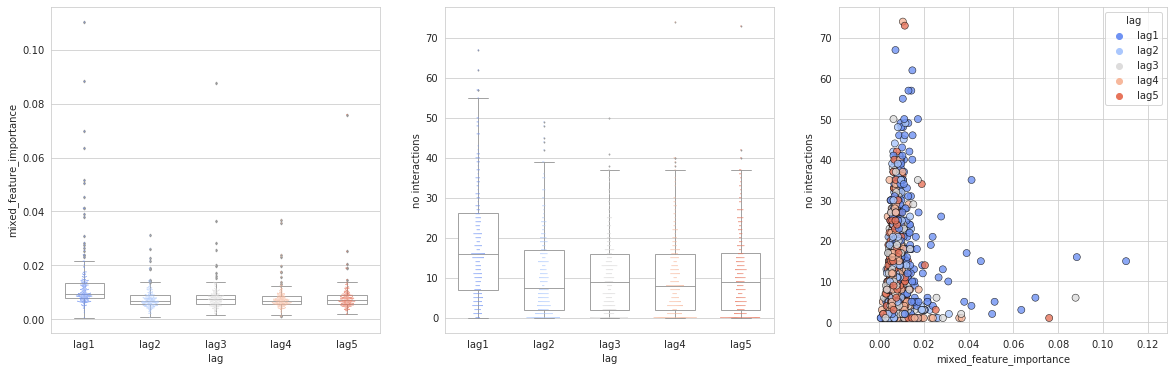

In [76]:
#plot strength of interaction on each lag
x, y = STRENGTH_N_INTERACTIONS_DF["mixed_feature_importance"], STRENGTH_N_INTERACTIONS_DF["no interactions"]


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
sns.boxplot(data=STRENGTH_N_INTERACTIONS_DF,
            x = 'lag',
            y = 'mixed_feature_importance',
            color='white',
            linewidth=.9,
            width=.6,
            fliersize=2, ax=axes[0])

sns.swarmplot(data=STRENGTH_N_INTERACTIONS_DF,
              x = 'lag',
              y = 'mixed_feature_importance',
              s=1,
              palette='coolwarm', ax=axes[0])

sns.boxplot(data=N_INTERACTIONS_DF,
            x = 'lag',
            y = 'no interactions',
            color='white',
            linewidth=.9,
            fliersize=1,
            width=.6,
           ax=axes[1])

sns.swarmplot(data=N_INTERACTIONS_DF,
              x = 'lag',
              y = 'no interactions',
              s=1,
              palette='coolwarm',
             ax=axes[1])

sns.scatterplot(x=x,
                y=y,
                s=50,
                alpha=.8,edgecolor='k',
                palette='coolwarm',
                hue = STRENGTH_N_INTERACTIONS_DF['lag'], ax=axes[2])

### count number of interactions between different and within the same 

In [114]:
def count_within_between_group_interactions(level):
    
    lags = TAXONOMY_INTERACTIONS.lag.unique()

    WITHIN_DF = []
    BETWEEN_DF = []

    for feature in TAXONOMY_INTERACTIONS['feature_{}'.format(level)].unique():

        no_within_interactions_l = []
        no_between_interactions_l = []

        for lag in lags:
            no_within_interactions = TAXONOMY_INTERACTIONS[(TAXONOMY_INTERACTIONS['feature_{}'.format(level)] == feature) &
                                                           (TAXONOMY_INTERACTIONS['target_{}'.format(level)] == feature) & 
                                                           (TAXONOMY_INTERACTIONS.lag == lag)]


            no_between_interactions = TAXONOMY_INTERACTIONS[(TAXONOMY_INTERACTIONS['feature_{}'.format(level)] == feature) &
                                                           (TAXONOMY_INTERACTIONS['target_{}'.format(level)] != feature) & 
                                                           (TAXONOMY_INTERACTIONS.lag == lag)]

            no_within_interactions_l.append(no_within_interactions.shape[0])
            no_between_interactions_l.append(no_between_interactions.shape[0])



        within_df = pd.DataFrame(list(zip(lags, no_within_interactions_l)), columns = ['lag', 'no_interactions'])
        within_df['name'] = feature

        between_df = pd.DataFrame(list(zip(lags, no_between_interactions_l)), columns = ['lag', 'no_interactions'])
        between_df['name'] = feature

        WITHIN_DF.append(within_df)
        BETWEEN_DF.append(between_df)

    WITHIN_DF = pd.concat(WITHIN_DF)
    WITHIN_DF['type'] = 'within group'
    BETWEEN_DF = pd.concat(BETWEEN_DF)
    BETWEEN_DF['type'] = 'between group'

    BETWEEN_WITHIN_INTERACTIONS_DF = WITHIN_DF.append(BETWEEN_DF)
    
    return BETWEEN_WITHIN_INTERACTIONS_DF

In [115]:
phylum_df = count_within_between_group_interactions('p')
class_df = count_within_between_group_interactions('c')
order_df = count_within_between_group_interactions('o')
family_df = count_within_between_group_interactions('f')
genus_df = count_within_between_group_interactions('g')

In [165]:
def plot_taxonomic_interactions_barplot(df, level, size = (5, 7)):
    
    plt.figure(figsize=size)
    sns.barplot(data=df,
                y = 'name',
                x = 'no_interactions',
                hue = 'type',
                errwidth=0,
                edgecolor='k',
                linewidth=1, 
                palette='coolwarm')

    plt.xlabel('', size=18)
    plt.yticks(size=14)
    plt.xticks(size=14)
    plt.ylabel('', size=18)
    plt.tight_layout()
    plt.savefig('eccb_plots/{}_number_of_interactions.png'.format(level))
    plt.show()

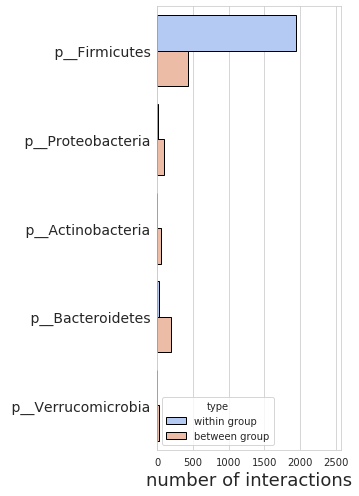

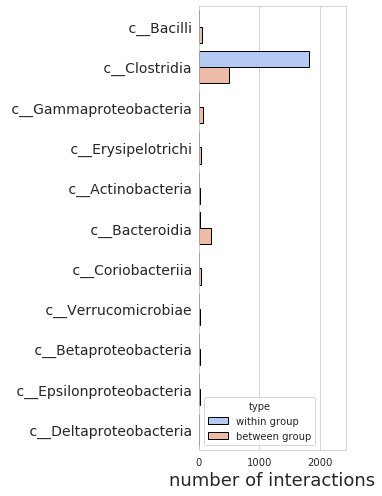

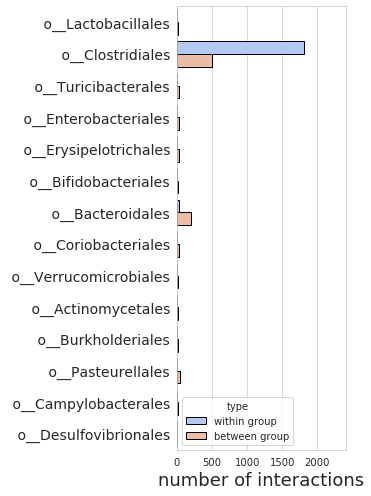

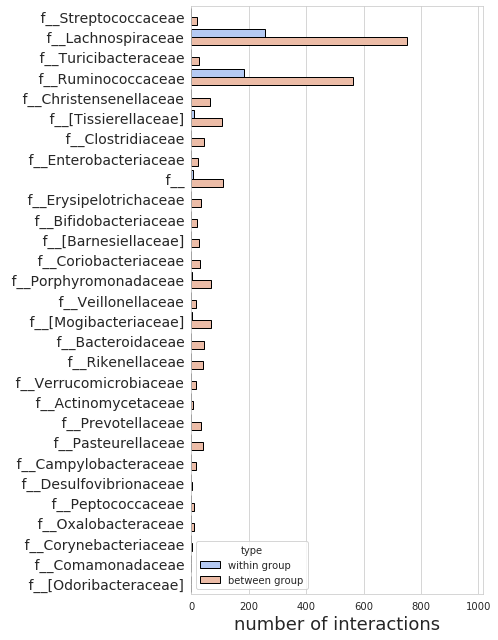

In [164]:
plot_taxonomic_interactions_barplot(phylum_df, 'phylum')
plot_taxonomic_interactions_barplot(class_df, 'class')
plot_taxonomic_interactions_barplot(order_df, 'order')
plot_taxonomic_interactions_barplot(family_df, 'family', size=(7, 9))

### analyse with which family does Lachnospiraceae and Ruminococcae interact the most

In [156]:
Lachnospiraceae_df = TAXONOMY_INTERACTIONS[TAXONOMY_INTERACTIONS.feature_f == ' f__Lachnospiraceae']
Lachnospiraceae_interactions_df = pd.DataFrame.from_dict(Counter(Lachnospiraceae_df.target_f), orient='index').reset_index()

Ruminococcaceae_df = TAXONOMY_INTERACTIONS[TAXONOMY_INTERACTIONS.feature_f == ' f__Ruminococcaceae']
Ruminococcaceae_interactions_df = pd.DataFrame.from_dict(Counter(Ruminococcaceae_df.target_f), orient='index').reset_index()

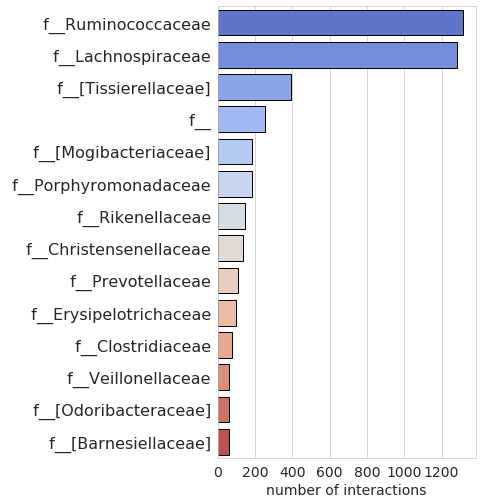

In [161]:
plt.figure(figsize=(7, 7))
sns.barplot(data=Lachnospiraceae_interactions_df.sort_values(by = [0], ascending=False).head(15), 
            y = 'index', x = Lachnospiraceae_interactions_df[0], palette='coolwarm', edgecolor='k')
plt.yticks(size=16)
plt.tight_layout()
plt.xlabel('number of interactions', size=14)
plt.xticks(size=14)
plt.ylabel('')
plt.savefig('eccb_plots/Lachnospiraceae.png')

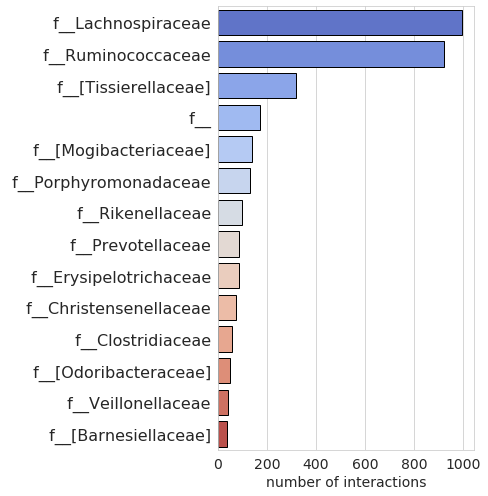

In [159]:
plt.figure(figsize=(7, 7))
sns.barplot(data=Ruminococcaceae_interactions_df.sort_values(by = [0], ascending=False).head(15), 
            y = 'index', x = Ruminococcaceae_interactions_df[0], palette='coolwarm', edgecolor='k')
plt.yticks(size=16)
plt.xlabel('number of interactions', size=14)
plt.xticks(size=14)
plt.tight_layout()
plt.ylabel('')
plt.savefig('eccb_plots/Ruminococcaceae.png')